# Load a few cases and visualize data

This code can run on local -- I will run the training on MEL

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit


In [2]:
def read_data(file_dir, fname, i):
    
    fname_tmp = file_dir + "{:04}".format(i) + fname
    data = np.load(fname_tmp)
    
    return data

In [3]:
file_dir='../public_training_data/'
fname_gt ='_IVIMParam.npy'
fname_gtDWI ='_gtDWIs.npy'
fname_tissue ='_TissueType.npy'
fname_noisyDWIk = '_NoisyDWIk.npy'

#Nx = 200
#Ny = 200
b = np.array([0, 5, 50, 100, 200, 500, 800, 1000])

random_image_number = 42
# load gt data
params = read_data(file_dir, fname_gt, random_image_number)
clean = read_data(file_dir, fname_gtDWI, random_image_number)
# load noisy data and perform baseline reconstruction
k= read_data(file_dir, fname_noisyDWIk, random_image_number)
# load tissue type data
tissue = read_data(file_dir, fname_tissue, random_image_number)

# The maps of ground truth tissue parameters

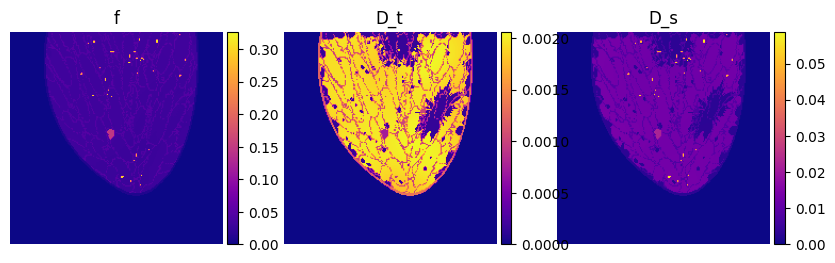

In [4]:
titles = ['f', 'D_t', 'D_s']
fig, ax = plt.subplots(1,3, figsize=(10,55))
for i in range(3):
    im = ax[i].imshow(params[:,:,i], cmap='plasma')
    ax[i].axis('off')
    ax[i].set_title(f'{titles[i]}')
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

# Noisy vs Clean

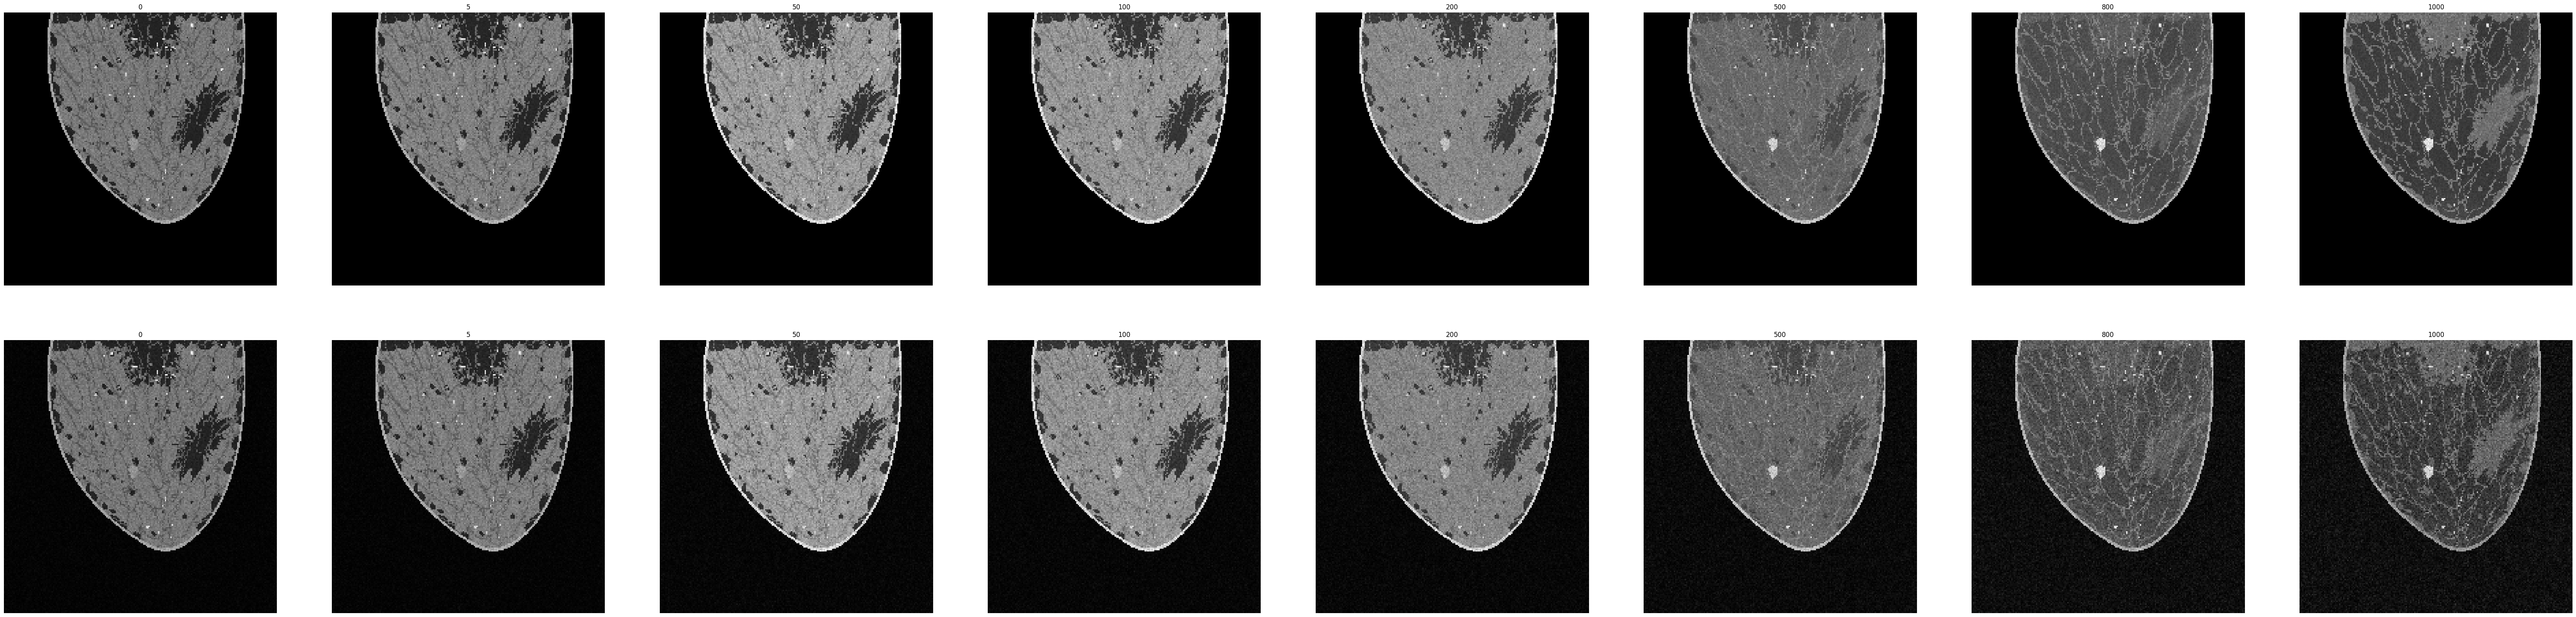

In [5]:

fig, ax = plt.subplots(2,8, figsize=(85,20))
for i in range(8):
    im = ax[0, i].imshow(np.abs(clean[:,:,i]), cmap='gray')
    ax[0,i].axis('off')
    ax[0,i].set_title(f'{b[i]}')
    im = ax[1, i].imshow(np.abs(np.fft.ifft2(k[:,:,i], axes=(0,1) ,norm='ortho')), cmap='gray')
    ax[1,i].axis('off')
    ax[1,i].set_title(f'{b[i]}')

# Calculate statistics of Real vs Imaginary noise and check if they are the same distribution

In [6]:
from tqdm import tqdm
pure_noise_re = {i:[] for i in range(8)}
pure_noise_im = {i:[] for i in range(8)}

for image_number in tqdm(range(1, 101)):
    # load gt data
    params = read_data(file_dir, fname_gt, image_number)
    clean = read_data(file_dir, fname_gtDWI, image_number)
    # load noisy data and perform baseline reconstruction
    k = read_data(file_dir, fname_noisyDWIk, image_number)
    # load tissue type data
    tissue = read_data(file_dir, fname_tissue, image_number)

    for b_value in range(8):

        clean_real = np.real(clean[:, :, b_value])
        noisy_real = np.real(np.fft.ifft2(k[:,:,b_value], axes=(0,1) ,norm='ortho'))
        coordBody = np.argwhere(tissue==8)
        pure_noise_re[b_value].append(noisy_real[coordBody[:,0], coordBody[:,1]] - clean_real[coordBody[:,0], coordBody[:,1]])

    for b_value in range(8):

        clean_img = np.imag(clean[:, :, b_value])
        noisy_img = np.imag(np.fft.ifft2(k[:,:,b_value], axes=(0,1) ,norm='ortho'))
        coordBody = np.argwhere(tissue==8)
        pure_noise_im[b_value].append(noisy_img[coordBody[:,0], coordBody[:,1]]- clean_img[coordBody[:,0], coordBody[:,1]])


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 26.48it/s]


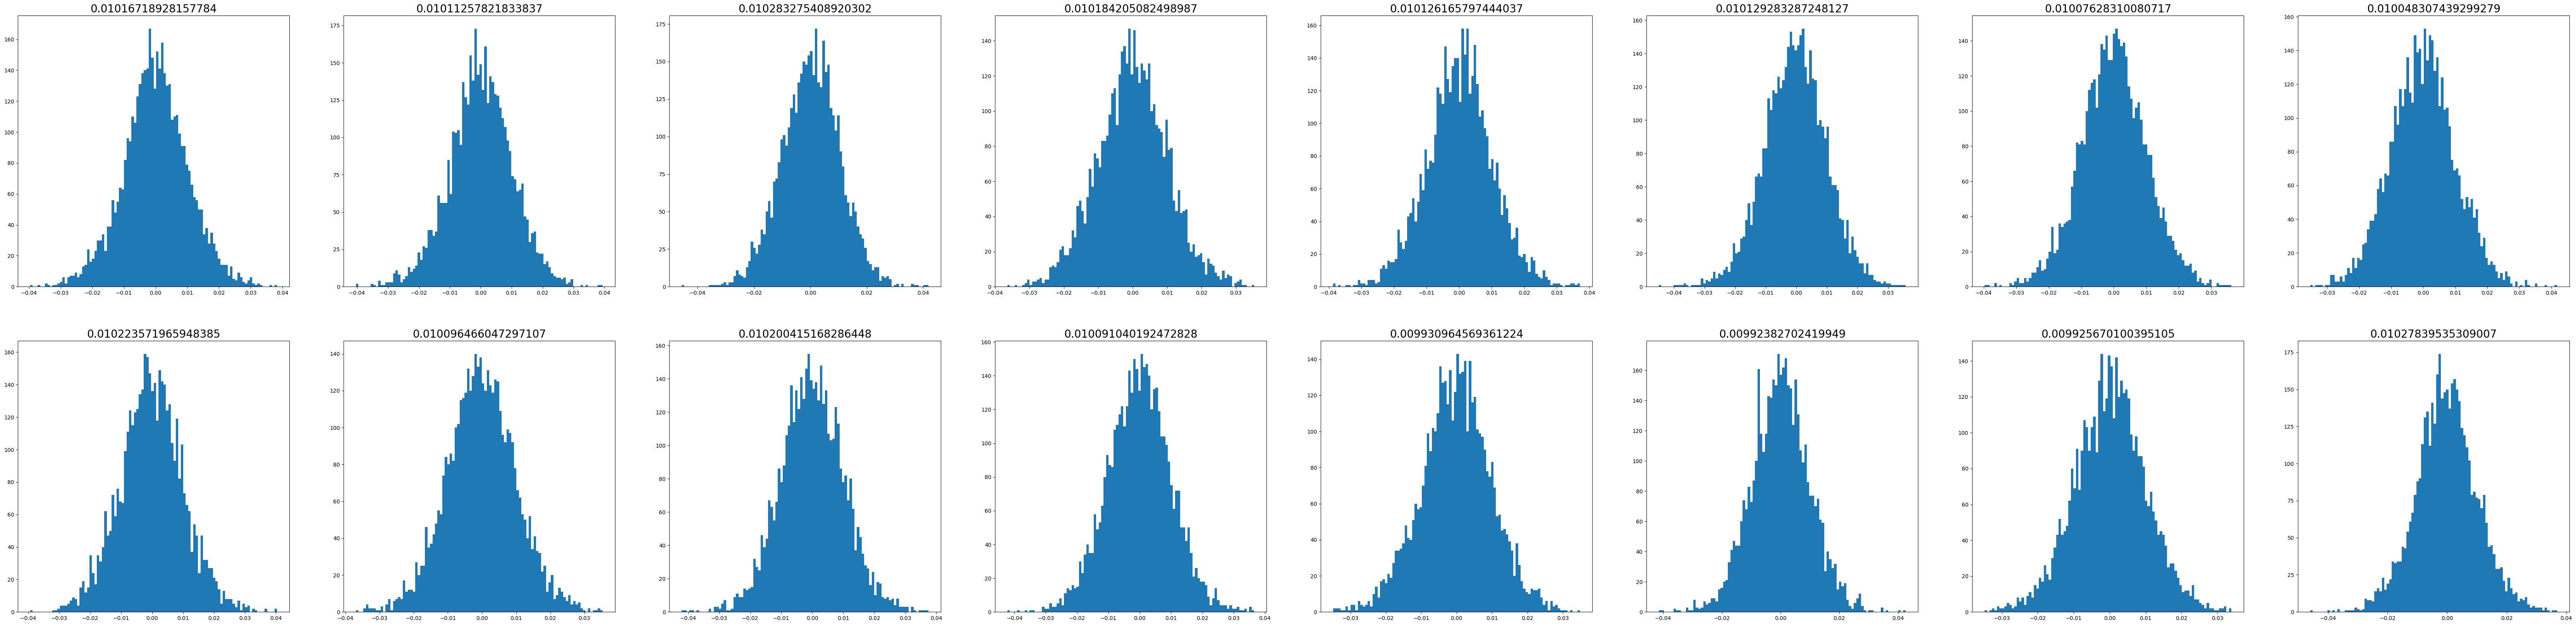

In [7]:
fig, ax = plt.subplots(2,8, figsize=(85,20))
for b_value in range(8):
    pure_noise_re[b_value] = np.concatenate(pure_noise_re[b_value]).ravel()
    ax[0, b_value].hist(pure_noise_re[b_value], bins=100)
    ax[0, b_value].set_title(np.std(np.asarray(pure_noise_re[b_value])), fontsize=20)

    pure_noise_im[b_value] = np.concatenate(pure_noise_im[b_value]).ravel()
    ax[1, b_value].hist(pure_noise_im[b_value], bins=100)
    ax[1, b_value].set_title(np.std(np.asarray(pure_noise_im[b_value])), fontsize=20)


# Estimate Parameter distributions 

100%|██████████| 1000/1000 [00:12<00:00, 82.26it/s]


Text(0.5, 1.0, 'D_star')

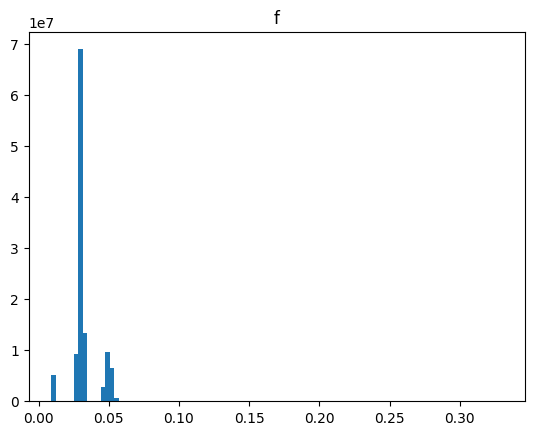

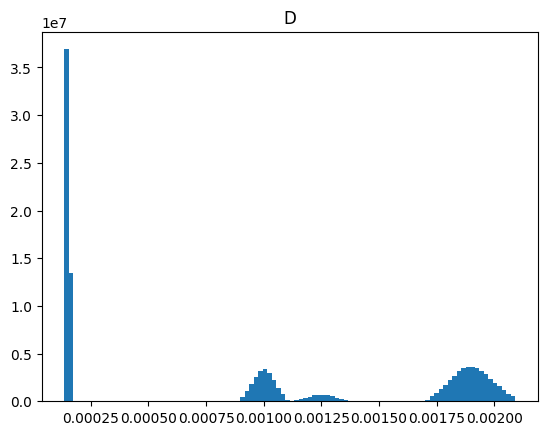

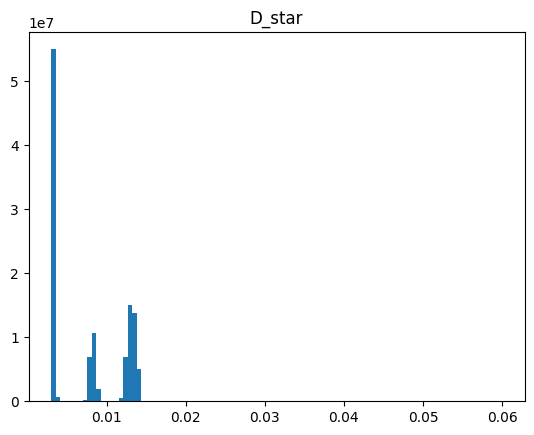

In [8]:
from tqdm import tqdm
f = []
D = []
D_star = []
for image_number in tqdm(range(1, 1001)):
    # load gt data
    params = read_data(file_dir, fname_gt, image_number)
    clean = read_data(file_dir, fname_gtDWI, image_number)
    f_measurement = params[:, :, 0]
    D_measurement = params[:, :, 1]
    D_star_measurement = params[:, :, 2]
    coordBody = np.argwhere(clean > 0)
    f.append(f_measurement[coordBody[:,0], coordBody[:,1]])
    D.append(D_measurement[coordBody[:,0], coordBody[:,1]])
    D_star.append(D_star_measurement[coordBody[:,0], coordBody[:,1]])


f = np.concatenate(f).ravel()
a = plt.hist(f, bins=100)
plt.title('f')

plt.figure()
D = np.concatenate(D).ravel()
a = plt.hist(D, bins=100)
plt.title('D')

plt.figure()
D_star = np.concatenate(D_star).ravel()
a = plt.hist(D_star, bins=100)
plt.title('D_star')


# Implement NLLS-based baseline and calculate results

In [21]:
def rRMSE(x,y,t, is_f=False):
    
    Nx, Ny = x.shape

    t_tmp = np.reshape(t, (Nx*Ny,))
    tumor_indice = np.argwhere(t_tmp == 8)
    non_tumor_indice = np.argwhere(t_tmp != 8)
    non_air_indice = np.argwhere(t_tmp != 1)
    non_tumor_air_indice= np.intersect1d(non_tumor_indice,non_air_indice)
    
    x_tmp = np.reshape(x, (Nx*Ny,))
    x_t = x_tmp[tumor_indice]
    x_nt = x_tmp[non_tumor_air_indice]
    
    y_tmp = np.reshape(y, (Nx*Ny,))
    y_t = y_tmp[tumor_indice]
    y_nt = y_tmp[non_tumor_air_indice]
    
    # tumor region
    tmp1 = np.sqrt(tumor_indice.shape[0]) if is_f else np.sqrt(np.sum(np.square(y_t)))
    tmp2 = np.sqrt(np.sum(np.square(x_t-y_t)))
    z_t = tmp2 / tmp1
    
    # non-tumor region
    tmp1 = np.sqrt(non_tumor_air_indice.shape[0]) if is_f else np.sqrt(np.sum(np.square(y_nt)))
    tmp2 = np.sqrt(np.sum(np.square(x_nt-y_nt)))
    z_nt = tmp2 / tmp1
    
    return z_t, z_nt

def rRMSE_per_case(x_f,x_dt,x_ds,y_f,y_dt,y_ds,t):
    
    
    R_f_t, R_f_nt = rRMSE(x_f, y_f, t, is_f=True)
    R_Dt_t, R_Dt_nt = rRMSE(x_dt, y_dt, t)
    R_Ds_t, R_Ds_nt = rRMSE(x_ds, y_ds, t)
    
    z =  (R_f_t + R_Dt_t + R_Ds_t)/3 + (R_f_nt + R_Dt_nt)/2
    
    z_t =  (R_f_t + R_Dt_t + R_Ds_t)/3
    
    return z, z_t


def rRMSE_all_cases(x_f,x_dt,x_ds,y_f,y_dt,y_ds,t):
    
    z = np.empty([x_f.shape[2]])
    z_t = np.empty([x_f.shape[2]])
    
    for i in range(x_f.shape[2]):
        z[i], z_t[i] = rRMSE_per_case(x_f[:,:,i],x_dt[:,:,i],x_ds[:,:,i],y_f[:,:,i],y_dt[:,:,i],y_ds[:,:,i],t[:,:,i]) 
        
    return np.average(z), np.average(z_t)

In [10]:
def funcBiExp(b, f, Dt, Ds):
    ## Units
    # b: s/mm^2
    # D: mm^2/s
    return (1.-f) * np.exp(-1.*Dt * b) + f * np.exp(-1.*Ds * b)

In [11]:
def fit_biExponential_model(arr3D_img, arr1D_b):
    

    arr2D_coordBody = np.argwhere(arr3D_img[:,:,0]>0)
    arr2D_fFitted = np.zeros_like(arr3D_img[:,:,0])
    arr2D_DtFitted = np.zeros_like(arr3D_img[:,:,0])
    arr2D_DsFitted = np.zeros_like(arr3D_img[:,:,0])

    for arr1D_coord in arr2D_coordBody:
        try:
            popt, pcov = curve_fit(funcBiExp, arr1D_b[1:]-arr1D_b[0], arr3D_img[arr1D_coord[0],arr1D_coord[1],1:]/arr3D_img[arr1D_coord[0],arr1D_coord[1],0]
                                , p0=(0.15,1.5e-3,8e-3), bounds=([0, 0, 3.0e-3], [1, 2.9e-3, np.inf]), method='trf')

        except:
            popt = [0, 0, 0]
            print('Coord {} fail to be fitted, set all parameters as 0'.format(arr1D_coord))

        arr2D_fFitted[arr1D_coord[0], arr1D_coord[1]] = popt[0]
        arr2D_DtFitted[arr1D_coord[0], arr1D_coord[1]] = popt[1]
        arr2D_DsFitted[arr1D_coord[0], arr1D_coord[1]] = popt[2]

    return np.concatenate((arr2D_fFitted[:,:,np.newaxis],arr2D_DtFitted[:,:,np.newaxis],arr2D_DsFitted[:,:,np.newaxis]), axis=2)

In [23]:
num_cases = 2
rRMSE_case =np.empty([num_cases])
rRMSE_t_case =np.empty([num_cases])
b = np.array([0, 5, 50, 100, 200, 500, 800, 1000])


for image_number in range(num_cases):
    params = read_data(file_dir, fname_gt, image_number + 1)
    clean = read_data(file_dir, fname_gtDWI, image_number + 1)
    k = read_data(file_dir, fname_noisyDWIk, image_number + 1)
    noisy = np.abs(np.fft.ifft2(k, axes=(0,1) ,norm='ortho'))
    arr3D_fittedParams = fit_biExponential_model(noisy, b)
    tissue = read_data(file_dir, fname_tissue, image_number + 1)
    rRMSE_case[image_number], rRMSE_t_case[image_number] = rRMSE_per_case(arr3D_fittedParams[:,:,0], arr3D_fittedParams[:,:,1], arr3D_fittedParams[:,:,2],\
                                                        params[:,:,0], params[:,:,1], params[:,:,2], tissue)
    print(f'RMSE ALL = {rRMSE_case[image_number]}\nRMSE tumor = {rRMSE_t_case[image_number]}')
rRMSE_final_1 = np.average(rRMSE_case)
rRMSE_final_tumor_1 = np.average(rRMSE_t_case)
print('-----')
print(f'Total RMSE all {rRMSE_final_1}\nRMSE tumor {rRMSE_final_tumor_1}')

RMSE ALL = 1.1012512287557
RMSE tumor = 0.8738487239978973
RMSE ALL = 0.7486812841341808
RMSE tumor = 0.526248729955413
-----
Total RMSE all 0.9249662564449403
RMSE tumor 0.7000487269766551
